# **당신이 가려는 회사가 칼퇴가능할지 지도로 미리 알아보자!**


# 개요

*  (목적) 본 분석의 목적은 출퇴근 러시아워의 직장 인근 지하철역, 버스정류장 승하차자 수 데이터를 통해 직장의 출퇴근 시간 자율성을 확인하고, 출퇴근 시간대의 자유로움을 비교하는 것입니다.
  
* (방법) 이를 위해 지하철역, 버스정류장의 위경도 데이터와 위치별 시간대별 승하차자 인원 데이터를 활용하여 기업의 출퇴근 시간 경직성을 확인합니다. 더 나아가 출퇴근 시간이 경직적인 정도가 기업문화에 어떤 영향을 미치는지도 확인해보고자 합니다.

* (데이터) 2022년 서울시 지하철역, 버스정류장 시간대별 교통카드 승하차 데이터와 본사가 서울에 위치한 100대 기업 및 공공기관 위치 정보를 활용합니다.




# 패키지 install and import

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas
!pip install mapclassify
!pip install folium
!pip install geopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (17.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
import mapclassify
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import folium
import zipfile
import matplotlib.pyplot as plt
from matplotlib import rc
from shapely.geometry import Point, Polygon, LineString
from shapely import wkt
from pyproj import CRS
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import zipfile
import math
from geopy.geocoders import Nominatim
geo_local = Nominatim(user_agent='South Korea')

# 필요데이터 가져오기

In [ ]:
# 2022서울 버스정류장 승하차데이터
!gdown --id 1LKD6uCtPX_PHoylIT_YQV50uDNhR95YX
businout_2022=pd.read_csv('businout_2022.csv',encoding='cp949')
# 2022서울 지하철역 승하차데이터
!gdown --id 1gIn8e5pUqi8TvPmHulUIgJzP4j4CUfju
subinout_2022=pd.read_csv('subinout_2022.csv',encoding='cp949')

# 서울 버스정류장 위경도 데이터
!gdown --id 1MymVvcntscd577PqiF6GYkdui8N28Zkp
Busloc=pd.read_excel('202103_1_bus_BaseInfo.xlsx', sheet_name = 0)
# 버스루트 데이터
BusRoute=pd.read_excel('202103_1_bus_BaseInfo.xlsx', sheet_name = 1)
# 버스루트 정차 데이터
BusRouteStop_202103=pd.read_excel('202103_1_bus_BaseInfo.xlsx', sheet_name = 2)

# 서울 지하철역 위경도 데이터
!gdown --id 1DnZpw1sDMR9TDp9PygYsmddFZ4dPJ-Sb
Subloc=pd.read_excel('202103_2_sub_BaseInfo.xlsx', sheet_name = 0)
# 지하철 Xfer 데이터
SubXfer=pd.read_excel('202103_2_sub_BaseInfo.xlsx', sheet_name = 1)
# 지하철루트 데이터
SubRoute =pd.read_excel('202103_2_sub_BaseInfo.xlsx', sheet_name = 2)
# 지하철루트 정차 데이터
SubRouteStop = pd.read_excel('202103_2_sub_BaseInfo.xlsx', sheet_name = 3)
# 지하철역 정차 시각 데이터
SubStopTime = pd.read_excel('202103_2_sub_BaseInfo.xlsx', sheet_name = 4)
# 한국 100대 기업 본사 사옥 위치 데이터
!gdown --id 1nEUZd1LQ3OtpPezOStuZ9Peay_9qFqGw
company_address = pd.read_csv('company_address.csv',encoding='utf-8')
# 서울 본사 둔 공공기관, 공기업 위치 데이터(알리오)
!gdown --id 1DJ5TVhfHCHAbHg8cPo68RHXpGvTfe6uo
public_company_address = pd.read_excel('public_company_address.xlsx', sheet_name = 0)

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1LKD6uCtPX_PHoylIT_YQV50uDNhR95YX
To: /content/businout_2022.csv
100% 14.9M/14.9M [00:00<00:00, 167MB/s]


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gIn8e5pUqi8TvPmHulUIgJzP4j4CUfju
To: /content/subinout_2022.csv
100% 20.2M/20.2M [00:00<00:00, 71.0MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1MymVvcntscd577PqiF6GYkdui8N28Zkp
To: /content/202103_1_bus_BaseInfo.xlsx
100% 27.4M/27.4M [00:00<00:00, 34.8MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://d

/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# 승하차시각 전처리

# 러시아워대 승하차 집중비중 생성
>>*우리나라 러시아워(버스전용차로 기준)*
*  (오전) 07:00 to 10:00
*  (오후) 17:00 to 21:00 -> 17:00~19:00
*  (야근) 20:00 to 22:00

 - 오전 러시아워에 하차자 비중(MorningRushratio)이 높고, 오후 러시아워에 승차자 비중(OffRushratio)이 높은 곳일수록 출퇴근 시간이 경직적(정시 출퇴근 준수)일 것으로 가정함.
 - 반대로, 러시아워 승하차자 비중 낮은 곳은 출퇴근 시간이 유연(근무시간이 자유롭거나, 야근을 많이함)할 것으로 가정함.
 - 하지만 20시, 21시 퇴근은 통상적으로 야근으로 취급되므로 퇴근러시아워 시간대는 17:00~19:00으로 제한
   - (MorningRushratio) = (AM07:00~10:00하차인원)/(전체시간대하차인원)
   - (OffRushratio) = (PM17:00~21:00승차인원)/(전체시간대승차인원)


In [ ]:
# 버스승하차시각 전처리
# 승하차시각, 표준정류장id만 있는 데이터
businout_2022_ids=businout_2022.iloc[:,3:54]
# 표준버스정류장ID가 같으면 승하차시간 합쳐 새로운 df 만들기
# businout_2022_ids.groupby('표준버스정류장ID').[IN[i]].apply(lambda x: x.astype(int).sum())
businout_2022_IN = businout_2022_ids.groupby(['표준버스정류장ID'])[['00시승차총승객수', '1시승차총승객수','2시승차총승객수','3시승차총승객수','4시승차총승객수','5시승차총승객수','6시승차총승객수','7시승차총승객수','8시승차총승객수','9시승차총승객수','10시승차총승객수','11시승차총승객수','12시승차총승객수','13시승차총승객수','14시승차총승객수','15시승차총승객수','16시승차총승객수','17시승차총승객수','18시승차총승객수','19시승차총승객수','20시승차총승객수','21시승차총승객수','22시승차총승객수','23시승차총승객수']].sum()
businout_2022_OUT = businout_2022_ids.groupby(['표준버스정류장ID'])[['00시하차총승객수', '1시하차총승객수','2시하차총승객수','3시하차총승객수','4시하차총승객수','5시하차총승객수','6시하차총승객수','7시하차총승객수','8시하차총승객수','9시하차총승객수','10시하차총승객수','11시하차총승객수','12시하차총승객수','13시하차총승객수','14시하차총승객수','15시하차총승객수','16시하차총승객수','17시하차총승객수','18시하차총승객수','19시하차총승객수','20시하차총승객수','21시하차총승객수','22시하차총승객수','23시하차총승객수']].sum()

In [ ]:
# 지하철 승하차시각 전처리
# 사용월이 2022년 1월~2022년 10월인 데이터
subinout_2022['사용월'] = subinout_2022['사용월'].astype(str)
subinout_2022 = subinout_2022[subinout_2022['사용월'].str.contains("2022")]
# 필요컬럼 [2:53](승하차시각, 지하철역만 있는 데이터)
subinout_2022_ids=subinout_2022.iloc[:,2:51]
# '지하철역' 이름 같으면 승하차시간 합쳐 새로운 df 만들기
subinout_2022_IN = subinout_2022_ids.groupby(['지하철역'])[['00시-01시 승차인원', '01시-02시 승차인원','02시-03시 승차인원','03시-04시 승차인원','04시-05시 승차인원','05시-06시 승차인원','06시-07시 승차인원','07시-08시 승차인원','08시-09시 승차인원','09시-10시 승차인원','10시-11시 승차인원','11시-12시 승차인원','12시-13시 승차인원','13시-14시 승차인원','14시-15시 승차인원','15시-16시 승차인원','16시-17시 승차인원','17시-18시 승차인원','18시-19시 승차인원','19시-20시 승차인원','20시-21시 승차인원','21시-22시 승차인원','22시-23시 승차인원','23시-24시 승차인원']].sum()
subinout_2022_OUT=subinout_2022_ids.groupby(['지하철역'])[['00시-01시 하차인원','01시-02시 하차인원','02시-03시 하차인원','03시-04시 하차인원','04시-05시 하차인원','05시-06시 하차인원','06시-07시 하차인원','07시-08시 하차인원','08시-09시 하차인원','09시-10시 하차인원','10시-11시 하차인원','11시-12시 하차인원','12시-13시 하차인원','13시-14시 하차인원','14시-15시 하차인원','15시-16시 하차인원','16시-17시 하차인원','17시-18시 하차인원','18시-19시 하차인원','19시-20시 하차인원','20시-21시 하차인원','21시-22시 하차인원','22시-23시 하차인원','23시-24시 하차인원']].sum()

(버스)러시아워대 승하차 집중 비중 생성

In [ ]:
# (오전)07:00∼10:00 에 하차자합
businout_2022_OUT['MorningRush']= businout_2022_OUT.iloc[:, 7:10].sum(axis=1)
# 전체시간대 하차자합
businout_2022_OUT['sumalltime']=businout_2022_OUT.iloc[:,0:24].sum(axis=1)
# 모닝러시 비중(MorningRushratio)
businout_2022_OUT['MorningRushratio']=businout_2022_OUT['MorningRush']/businout_2022_OUT['sumalltime']

# (오후)17:00∼19:00(토·공휴일 제외) 에 승차자합
businout_2022_IN['OffRush']= businout_2022_OUT.iloc[:, 17:19].sum(axis=1)

# (야근)20:00∼22:00(토·공휴일 제외) 에 승차자합
businout_2022_IN['NightRush']= businout_2022_OUT.iloc[:, 20:22].sum(axis=1)

# 전체 시간대 승차자합
businout_2022_IN['sumalltime']=businout_2022_IN.iloc[:,0:24].sum(axis=1)
# 퇴근 러시 비중(OffRushratio)
businout_2022_IN['OffRushratio']=businout_2022_IN['OffRush']/businout_2022_OUT['sumalltime']
# 야근 러시 비중(NightRushratio)
businout_2022_IN['NightRushratio']=businout_2022_IN['NightRush']/businout_2022_OUT['sumalltime']

# 표준 정류장 id기준으로 두 데이터 leftjoin
RushHours=pd.merge(businout_2022_OUT[['MorningRush','sumalltime','MorningRushratio']],businout_2022_IN[['OffRush','sumalltime','OffRushratio','NightRush','NightRushratio']],left_index=True,right_index=True,how='left')
# 컬럼 이름 변경
RushHours.rename({'sumalltime_x': 'sumalltime_OUT', 'sumalltime_y': 'sumalltime_IN'}, axis=1, inplace=True)
# 모든 시간대 승하차자합 sum인 칼럼 'SumINOUT'생성
RushHours['SumINOUT']=RushHours['sumalltime_OUT']+RushHours['sumalltime_IN']
# 러시아워대 승하차합이 0인 곳, 모든 시간대 승하차자합 sum이 0인 곳 제거
RushHours_nonzero = RushHours[~RushHours[list(['MorningRush','OffRush','SumINOUT'])].eq(0).all(axis = 1)]
# SumINOUT의 quantile로 범주화하기
RushHours_nonzero['SumINOUT']=RushHours_nonzero['sumalltime_OUT']+RushHours_nonzero['sumalltime_IN']
RushHours_nonzero_QTS= RushHours_nonzero['SumINOUT'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
RushHours_nonzero_QTS = RushHours_nonzero_QTS.tolist()
RushHours_nonzero_QTS.insert(0,0)
labels = ['최소~1q','~2q','~3q','~4q','~5q','~6q','~7q','~8q','~9q','~최대']
RushHours_nonzero['SumQuantile'] = pd.cut(RushHours_nonzero['SumINOUT'], bins=RushHours_nonzero_QTS, labels=labels, include_lowest=True)#객체의 가장 작은 값 포함 여부 지정(default는 FALSE)

(지하철)러시아워대 승하차 집중 비중 생성

In [ ]:
# (오전)07:00∼10:00에 하차자합
subinout_2022_OUT['MorningRush']= subinout_2022_OUT.iloc[:,7:10].sum(axis=1)
# 전체 시간대 하차자합
subinout_2022_OUT['sumalltime']=subinout_2022_OUT.iloc[:,0:24].sum(axis=1)
# 모닝러시 비중(MorningRushratio)
subinout_2022_OUT['MorningRushratio']=subinout_2022_OUT['MorningRush']/subinout_2022_OUT['sumalltime']

# (오후)17:00∼19:00(토·공휴일 제외) 에 승차자합
subinout_2022_IN['OffRush']= subinout_2022_IN.iloc[:, 17:19].sum(axis=1)

# (야근)20:00∼22:00(토·공휴일 제외) 에 승차자합
subinout_2022_IN['NightRush']= subinout_2022_IN.iloc[:, 20:22].sum(axis=1)

# 전체 시간대 승차자합
subinout_2022_IN['sumalltime']=subinout_2022_IN.iloc[:,0:24].sum(axis=1)
# 퇴근러시 비중(OffRushratio)
subinout_2022_IN['OffRushratio']=subinout_2022_IN['OffRush']/subinout_2022_IN['sumalltime']
# 야근 러시 비중(NightRushratio)
subinout_2022_IN['NightRushratio']=subinout_2022_IN['NightRush']/subinout_2022_IN['sumalltime']

# 표준 정류장 id기준으로 두 데이터 leftjoin
subRushHours=pd.merge(subinout_2022_OUT[['MorningRush','sumalltime','MorningRushratio']],subinout_2022_IN[['OffRush','sumalltime','OffRushratio','NightRush','NightRushratio']],left_index=True,right_index=True,how='left')
# 컬럼 이름 변경
subRushHours.rename({'sumalltime_x': 'sumalltime_OUT', 'sumalltime_y': 'sumalltime_IN'}, axis=1, inplace=True)
# 모든 시간대 승하차자합 sum인 칼럼 'SumINOUT'생성
subRushHours['SumINOUT']=subRushHours['sumalltime_OUT']+subRushHours['sumalltime_IN']
# 러시아워대 승하차합이 0인 곳, 모든 시간대 승하차자합 sum이 0인 곳 제거
subRushHours_nonzero = subRushHours[~subRushHours[list(['MorningRush','OffRush','SumINOUT'])].eq(0).all(axis = 1)]
# SumINOUT의 quantile로 범주화하기
subRushHours_nonzero['SumINOUT']=subRushHours_nonzero['sumalltime_OUT']+subRushHours_nonzero['sumalltime_IN']
subRushHours_nonzero_QTS= subRushHours_nonzero['SumINOUT'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
subRushHours_nonzero_QTS = subRushHours_nonzero_QTS.tolist()
subRushHours_nonzero_QTS.insert(0,0)
labels = ['최소~1q','~2q','~3q','~4q','~5q','~6q','~7q','~8q','~9q','~최대']
subRushHours_nonzero['SumQuantile'] = pd.cut(subRushHours_nonzero['SumINOUT'], bins=subRushHours_nonzero_QTS, labels=labels, include_lowest=True)#객체의 가장 작은 값 포함 여부 지정(default는 FALSE)

In [ ]:
RushHours_nonzero
subRushHours_nonzero

,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,SumQuantile
지하철역,,,,,,,,,,
4.19민주묘지,137896,859551,0.160428,128213,915829,0.139997,40850,0.044604,1775380,~3q
가능,281862,1774964,0.158799,212546,1855072,0.114576,84710,0.045664,3630036,~4q
가락시장,1202385,4538095,0.264954,900908,4353893,0.206920,370053,0.084994,8891988,~8q
가산디지털단지,9369569,15672965,0.597817,6380564,14983345,0.425844,1642796,0.109641,30656310,~최대
가양,956925,5391649,0.177483,814164,5564374,0.146317,267854,0.048137,10956023,~9q
...,...,...,...,...,...,...,...,...,...,...
회기,1113221,6777614,0.164250,1049322,7013792,0.149608,484409,0.069065,13791406,~9q
회룡,306043,3431783,0.089179,257382,3468240,0.074211,108742,0.031354,6900023,~7q
회현(남대문시장),2536189,6685428,0.379361,2003687,6389018,0.313614,616452,0.096486,13074446,~9q


> (MorningRushratio) 출근시간대 하차자 ratio\
> (OffRushratio) 퇴근시간대 승차자 ratio\
> (NightRushratio) reverse 칼퇴시간대 ratio.
   - 야근족 퇴근시간대인 20시~22시의 승차자 비중
   - 이 값이 높을수록 reverse-칼퇴하는(=야근하는) 회사

In [ ]:
#NightRushratio 를 10% percentile로 나누기
# SumINOUT의 quantile로 범주화하기
RushHours_nonzero_QTS= RushHours_nonzero['NightRushratio'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
RushHours_nonzero_QTS = RushHours_nonzero_QTS.tolist()
RushHours_nonzero_QTS.insert(0,0)

subRushHours_nonzero_QTS= subRushHours_nonzero['NightRushratio'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
subRushHours_nonzero_QTS = subRushHours_nonzero_QTS.tolist()
subRushHours_nonzero_QTS.insert(0,0)

RushHours_nonzero['NightrushQuantile'] = pd.cut(RushHours_nonzero['NightRushratio'], bins=RushHours_nonzero_QTS, labels=labels, include_lowest=True)
subRushHours_nonzero['NightrushQuantile'] = pd.cut(subRushHours_nonzero['NightRushratio'], bins=subRushHours_nonzero_QTS, labels=labels, include_lowest=True)

In [ ]:
subRushHours_nonzero

,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,SumQuantile,NightrushQuantile
지하철역,,,,,,,,,,,
4.19민주묘지,137896,859551,0.160428,128213,915829,0.139997,40850,0.044604,1775380,~3q,~4q
가능,281862,1774964,0.158799,212546,1855072,0.114576,84710,0.045664,3630036,~4q,~4q
가락시장,1202385,4538095,0.264954,900908,4353893,0.206920,370053,0.084994,8891988,~8q,~8q
가산디지털단지,9369569,15672965,0.597817,6380564,14983345,0.425844,1642796,0.109641,30656310,~최대,~9q
가양,956925,5391649,0.177483,814164,5564374,0.146317,267854,0.048137,10956023,~9q,~4q
...,...,...,...,...,...,...,...,...,...,...,...
회기,1113221,6777614,0.164250,1049322,7013792,0.149608,484409,0.069065,13791406,~9q,~7q
회룡,306043,3431783,0.089179,257382,3468240,0.074211,108742,0.031354,6900023,~7q,최소~1q
회현(남대문시장),2536189,6685428,0.379361,2003687,6389018,0.313614,616452,0.096486,13074446,~9q,~9q


# 버스·지하철 Location데이터(Busloc, Subloc) 전처리

## Busloc 전처리

In [ ]:
# Busloc의 Stop_ID를 뒤에서 9번째까지만 긁어오자.
Busloc['표준버스정류장ID'] = Busloc['Stop_ID'].str[-9:]
# '표준버스정류장ID'가 9자리 숫자형태 아닌것 드롭
Busloc = Busloc[pd.to_numeric(Busloc['표준버스정류장ID'], errors='coerce').notnull()]
Busloc['표준버스정류장ID'] = Busloc['표준버스정류장ID'].astype(str).astype(int)
# '표준버스정류장ID'를 KEY로 하여  RushHours_nonzero와 Busloc을 연결
Busloc.set_index('표준버스정류장ID', inplace=True)
paramap=pd.merge(RushHours_nonzero,Busloc[['Lati','Long','Stop_NM']],left_index=True,right_index=True,how='left')
# paramap의 Lati와 Long이 NaN인곳 수
paramap[['Lati','Long']].isna().sum()  
paramap.dropna(subset=['Lati', 'Long'],axis=0, inplace=True)
# 인덱스 해제
# paramap 의 표준버스정류장ID가 유니크한 값만 남겨두기
paramap['표준버스정류장ID'] = paramap.index
paramap.drop_duplicates(['표준버스정류장ID'], keep='first',inplace=True)

<ipython-input-11-96607be1733f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Busloc['표준버스정류장ID'] = Busloc['표준버스정류장ID'].astype(str).astype(int)


In [ ]:
paramap

,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,SumQuantile,NightrushQuantile,Lati,Long,Stop_NM,표준버스정류장ID
표준버스정류장ID,,,,,,,,,,,,,,,
100000001,2040,13094,0.155797,2239,14597,0.170994,727,0.055522,27691,~8q,~3q,37.569765,126.987750,종로2가사거리,100000001
100000002,28888,63889,0.452159,3131,73428,0.049007,1149,0.017984,137317,~최대,최소~1q,37.579183,126.996566,창경궁.서울대학교병원,100000002
100000003,24303,84079,0.289050,8558,122132,0.101785,3593,0.042734,206211,~최대,~2q,37.582671,126.998340,명륜3가.성대입구,100000003
100000004,4699,24228,0.193949,3683,20246,0.152014,1901,0.078463,44474,~9q,~5q,37.568579,126.987613,종로2가.삼일교,100000004
100000005,17841,73834,0.241637,9797,49052,0.132690,3543,0.047986,122886,~최대,~2q,37.586243,127.001744,혜화동로터리.여운형활동터,100000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277103814,0,1,0.000000,0,0,0.000000,0,0.000000,1,최소~1q,최소~1q,37.736113,126.718578,난방공사(경유),277103814
277104249,4,53,0.075472,17,1,0.320755,5,0.094340,54,최소~1q,~6q,37.537815,126.815691,고강지하차도입구(경유),277104249
277104250,56,189,0.296296,36,0,0.190476,10,0.052910,189,최소~1q,~3q,37.537420,126.815765,고강지하차도입구(경유),277104250


## Subloc 전처리

In [ ]:
# Subloc의 Stop_NM 을 '지하철역' 으로 rename 하고
Subloc = Subloc.rename(columns={'Stop_NM': '지하철역'})
# Subloc의 '지하철역'을 index로 지정

Subloc.set_index('지하철역', inplace=True)

# '지하철역'를 KEY로 하여  subRushHours_nonzero 와 Subloc 을 연결
subparamap=pd.merge(subRushHours_nonzero,Subloc[['Lati','Long']],left_index=True,right_index=True,how='left')
# subparamap의  Lati와 Long이 NaN인곳 수
subparamap[['Lati','Long']].isna().sum()
subparamap.dropna(subset=['Lati', 'Long'],axis=0, inplace=True)

# subparamap 의 인덱스(지하철역)가 유니크한 값만 남겨두기
subparamap = subparamap.groupby(subparamap.index).first()
subparamap

,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,SumQuantile,NightrushQuantile,Lati,Long
지하철역,,,,,,,,,,,,,
가능,281862,1774964,0.158799,212546,1855072,0.114576,84710,0.045664,3630036,~4q,~4q,37.748580,127.044210
가락시장,1202385,4538095,0.264954,900908,4353893,0.206920,370053,0.084994,8891988,~8q,~8q,37.492290,127.117790
가산디지털단지,9369569,15672965,0.597817,6380564,14983345,0.425844,1642796,0.109641,30656310,~최대,~9q,37.481590,126.882590
가양,956925,5391649,0.177483,814164,5564374,0.146317,267854,0.048137,10956023,~9q,~4q,37.561390,126.854460
가오리,120023,1113738,0.107766,99118,1140830,0.086882,34597,0.030326,2254568,~3q,최소~1q,37.641562,127.016798
...,...,...,...,...,...,...,...,...,...,...,...,...,...
회기,1113221,6777614,0.164250,1049322,7013792,0.149608,484409,0.069065,13791406,~9q,~7q,37.589460,127.057580
회룡,306043,3431783,0.089179,257382,3468240,0.074211,108742,0.031354,6900023,~7q,최소~1q,37.724380,127.047370
회현(남대문시장),2536189,6685428,0.379361,2003687,6389018,0.313614,616452,0.096486,13074446,~9q,~9q,37.558510,126.978250


# 지도에 러시아워승하차 집중도 높은 역 표시
- 분석 대상은 전체 시간대 승하차인원 상위 10%인 정류장 및 지하철역으로 한정
  * (이유) 오전 러시하차인원이 1명이고 다른 시간대에 0명인 한산한 정류장이 분석 대상에 포함되면, 이러한 정류장은 직장 근처가 아님에도 불구하고 1이라는 높은 Rushratio를 가질 것이기 때문

paramap과 subparamap 을 rowbind하여 subbusparamap으로 저장

In [ ]:
subbusparamap = pd.concat([paramap.iloc[:,0:13],subparamap.iloc[:,0:13]])

In [ ]:
subbusparamap

,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,SumQuantile,NightrushQuantile,Lati,Long
100000001,2040,13094,0.155797,2239,14597,0.170994,727,0.055522,27691,~8q,~3q,37.569765,126.987750
100000002,28888,63889,0.452159,3131,73428,0.049007,1149,0.017984,137317,~최대,최소~1q,37.579183,126.996566
100000003,24303,84079,0.289050,8558,122132,0.101785,3593,0.042734,206211,~최대,~2q,37.582671,126.998340
100000004,4699,24228,0.193949,3683,20246,0.152014,1901,0.078463,44474,~9q,~5q,37.568579,126.987613
100000005,17841,73834,0.241637,9797,49052,0.132690,3543,0.047986,122886,~최대,~2q,37.586243,127.001744
...,...,...,...,...,...,...,...,...,...,...,...,...,...
회기,1113221,6777614,0.164250,1049322,7013792,0.149608,484409,0.069065,13791406,~9q,~7q,37.589460,127.057580
회룡,306043,3431783,0.089179,257382,3468240,0.074211,108742,0.031354,6900023,~7q,최소~1q,37.724380,127.047370
회현(남대문시장),2536189,6685428,0.379361,2003687,6389018,0.313614,616452,0.096486,13074446,~9q,~9q,37.558510,126.978250
효창공원앞,721715,2629790,0.274438,559420,2706028,0.206731,186233,0.068822,5335818,~6q,~7q,37.538664,126.962345


(오전, 오후러시) 분석 대상만 sort
: 지하철, 버스 모든시간대 승하차인원 상위 10%의 역만 분석 대상


In [ ]:
subbusparamaphigh = subbusparamap[(subbusparamap['SumQuantile'] == '~최대')]

In [ ]:
subbusparamaphigh

,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,SumQuantile,NightrushQuantile,Lati,Long
100000002,28888,63889,0.452159,3131,73428,0.049007,1149,0.017984,137317,~최대,최소~1q,37.579183,126.996566
100000003,24303,84079,0.289050,8558,122132,0.101785,3593,0.042734,206211,~최대,~2q,37.582671,126.998340
100000005,17841,73834,0.241637,9797,49052,0.132690,3543,0.047986,122886,~최대,~2q,37.586243,127.001744
100000007,3213,13866,0.231718,1638,40142,0.118131,618,0.044569,54008,~최대,~2q,37.583295,126.970263
100000015,7268,38920,0.186742,6885,31386,0.176901,1590,0.040853,70306,~최대,~2q,37.580326,126.971050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
천호(풍납토성),1502081,9659958,0.155496,1516189,9112166,0.166392,876440,0.096183,18772124,~최대,~9q,37.538460,127.123900
청량리(서울시립대입구),1500882,10332915,0.145253,1571454,10213677,0.153858,737931,0.072249,20546592,~최대,~7q,37.580110,127.045040
합정,2810110,13035411,0.215575,2524707,12452276,0.202751,1853566,0.148854,25487687,~최대,~최대,37.550020,126.914530
혜화,2330623,9411182,0.247644,2102927,9322737,0.225570,1528671,0.163972,18733919,~최대,~최대,37.582340,127.001840


# 지하철역과 버스정거장의 러시아워대 집중도에 따라 Heat맵 그리기

In [ ]:
def get_center_latlong(subbusparamaphigh):
    centerlat = (subbusparamaphigh['Lati'].max() + subbusparamaphigh['Lati'].min()) / 2
    centerlong = (subbusparamaphigh['Long'].max() + subbusparamaphigh['Long'].min()) / 2
    return centerlat, centerlong

In [ ]:
import folium
import branca.colormap as cm#branca.colormap으로 색깔 바꿈
import folium.plugins
# MorningRushratio(모닝러시시간대 하차자 많은 버스정류장)
from folium.plugins import HeatMap
morningheat = subbusparamaphigh[["Lati", "Long", "MorningRushratio"]]
morningheat = morningheat.values
noonheat = subbusparamaphigh[["Lati", "Long", "OffRushratio"]]
noonheat = noonheat.values

nightheat = subbusparamaphigh[["Lati", "Long", "NightRushratio"]]
nightheat = nightheat.values

In [ ]:
center = get_center_latlong(subbusparamaphigh)
m = folium.Map(location=center, zoom_start=10)
HeatMap(morningheat).add_to(m)
HeatMap(noonheat).add_to(m)
title1_html = '''
             <h3 align="center" style="font-size:20px"><b>오전오후러시아워혼잡도 히트맵</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title1_html))

m.save('RushHeatmap.html')
m

* 지하철역과 버스정류장의 전체 시간대 승하차 인원이 상위 10%인 곳만이 분석 대상임
* 오전 러시아워시간대 하차자 비중이 높고, 오후 러시아워시간대 승차자 비중이 높으면 경직적 출퇴근시간이 존재하는 직장 주변으로 간주
* 그들 중 전체 승하차자 대비 러시아워시간대 승차(오후 러시)하차자(오전 러시) 비중이 집중되었을 경우 더 진한 붉은 색으로 표시되어 있음
* 그러한 지역은 영등포역-여의도역 일대, 을지로~서울역 일대,신촌로 일대, 역삼동 테헤란로 일대, 신림역 일대로 나타났음




In [ ]:
Morninghacha = folium.Map(location=center, zoom_start=10)
HeatMap(morningheat).add_to(Morninghacha)
title2_html = '''
             <h3 align="center" style="font-size:20px"><b>출근러시아워 하차자 히트맵</b></h3>
             '''
Morninghacha.get_root().html.add_child(folium.Element(title2_html))

Morninghacha.save('Morninghacha.html')
Morninghacha

In [ ]:
Noonseungcha = folium.Map(location=center, zoom_start=10)
HeatMap(morningheat).add_to(Noonseungcha)
title3_html = '''
             <h3 align="center" style="font-size:20px"><b>퇴근러시아워 승차자 히트맵</b></h3>
             '''
Noonseungcha.get_root().html.add_child(folium.Element(title3_html))

Noonseungcha.save('Noonseungcha.html')
Noonseungcha

In [ ]:
subbusparamap

Reversekaltoi = folium.Map(location=center, zoom_start=10)
HeatMap(nightheat).add_to(Reversekaltoi)
title3_html = '''
             <h3 align="center" style="font-size:20px"><b>REVERSE 칼퇴 승차자 히트맵</b></h3>
             '''
Reversekaltoi.get_root().html.add_child(folium.Element(title3_html))

Reversekaltoi.save('Reversekaltoi.html')
Reversekaltoi

In [ ]:
subbusparamaphigh

,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,SumQuantile,NightrushQuantile,Lati,Long
100000002,28888,63889,0.452159,3131,73428,0.049007,1149,0.017984,137317,~최대,최소~1q,37.579183,126.996566
100000003,24303,84079,0.289050,8558,122132,0.101785,3593,0.042734,206211,~최대,~2q,37.582671,126.998340
100000005,17841,73834,0.241637,9797,49052,0.132690,3543,0.047986,122886,~최대,~2q,37.586243,127.001744
100000007,3213,13866,0.231718,1638,40142,0.118131,618,0.044569,54008,~최대,~2q,37.583295,126.970263
100000015,7268,38920,0.186742,6885,31386,0.176901,1590,0.040853,70306,~최대,~2q,37.580326,126.971050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
천호(풍납토성),1502081,9659958,0.155496,1516189,9112166,0.166392,876440,0.096183,18772124,~최대,~9q,37.538460,127.123900
청량리(서울시립대입구),1500882,10332915,0.145253,1571454,10213677,0.153858,737931,0.072249,20546592,~최대,~7q,37.580110,127.045040
합정,2810110,13035411,0.215575,2524707,12452276,0.202751,1853566,0.148854,25487687,~최대,~최대,37.550020,126.914530
혜화,2330623,9411182,0.247644,2102927,9322737,0.225570,1528671,0.163972,18733919,~최대,~최대,37.582340,127.001840


야근시간대 승차자 집중도의 quantile에 따라 다른 색으로 표시하기

In [ ]:
reverse = subbusparamaphigh[['Lati','Long','NightRushratio','NightrushQuantile']]

(color 지정) reverse-칼퇴 확률이 가장높은 직장은 가장 진한 붉은색, reverse=칼퇴 확률이 가장 낮은 직장은 가장 연한 파란색


In [ ]:
reverse.describe()

,Lati,Long,NightRushratio
count,1313.000000,1313.000000,1313.000000
mean,37.541434,126.980647,0.083010
std,0.051452,0.076149,0.032778
min,37.266160,126.724480,0.013753
25%,37.501249,126.922148,0.057788
50%,37.537972,126.977332,0.078823
75%,37.577671,127.038758,0.105412
max,37.689195,127.169252,0.184895


NightRushratio의 min값인 0.013753 을 가장 연한 blue color의 하한으로,\
NightRushratio의 max값인 0.184895 을 가장 진한 red color의 상한으로 설정하기로 함

In [ ]:
colormap = cm.LinearColormap(colors=['lightblue','red'], index=[0.013753,0.184895],vmin=0.013753,vmax=0.184895)
reversemap = folium.Map(location=center, zoom_start=10)

lat = list(subbusparamaphigh.Lati)
lon = list(subbusparamaphigh.Long)
NightRushratiolist = list(subbusparamaphigh.NightRushratio)

for loc, N in zip(zip(lat, lon), NightRushratiolist):
    folium.Circle(
        location=loc,
        radius=100,
        fill=True,
        color=colormap(N),
        fill_opacity=0.5
    ).add_to(reversemap)

reversemap.add_child(colormap)

reversemapttle_html = '''
             <h3 align="center" style="font-size:20px"><b>Reverse-칼퇴확률 map</b></h3>
             '''
reversemap.get_root().html.add_child(folium.Element(reversemapttle_html))

reversemap.save('Reverse-칼퇴확률.html')
reversemap

subbusparamaphigh의 각 역들을 +-0.8km(통상적 도보 10분거리) 차이가 나도록 하는 minmax 위경도 범위 칼럼 생성

In [ ]:
subbusparamaphigh

,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,SumQuantile,NightrushQuantile,Lati,Long
100000002,28888,63889,0.452159,3131,73428,0.049007,1149,0.017984,137317,~최대,최소~1q,37.579183,126.996566
100000003,24303,84079,0.289050,8558,122132,0.101785,3593,0.042734,206211,~최대,~2q,37.582671,126.998340
100000005,17841,73834,0.241637,9797,49052,0.132690,3543,0.047986,122886,~최대,~2q,37.586243,127.001744
100000007,3213,13866,0.231718,1638,40142,0.118131,618,0.044569,54008,~최대,~2q,37.583295,126.970263
100000015,7268,38920,0.186742,6885,31386,0.176901,1590,0.040853,70306,~최대,~2q,37.580326,126.971050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
천호(풍납토성),1502081,9659958,0.155496,1516189,9112166,0.166392,876440,0.096183,18772124,~최대,~9q,37.538460,127.123900
청량리(서울시립대입구),1500882,10332915,0.145253,1571454,10213677,0.153858,737931,0.072249,20546592,~최대,~7q,37.580110,127.045040
합정,2810110,13035411,0.215575,2524707,12452276,0.202751,1853566,0.148854,25487687,~최대,~최대,37.550020,126.914530
혜화,2330623,9411182,0.247644,2102927,9322737,0.225570,1528671,0.163972,18733919,~최대,~최대,37.582340,127.001840


# 히트맵에 한국 공공기관 및 사기업 본사 위치 표시하기

In [ ]:
# 국내 사기업 중 "서울"이란 단어를 포함한 데이터만 seoul_company_address 변수에 담음
seoul_company_address = company_address[company_address['상세주소'].str.contains('서울')]
seoul_company_address
len(seoul_company_address)# 분석 대상은 서울에 본사가 있는 100대 기업 중 위경도 추출 가능한 총 32개 기업

32

In [ ]:
seoul_company_address

,기업명,상세주소,주소,위도,경도
1,SK이노베이션,서울특별시 종로구 종로 26,서울특별시 종로구 종로 26,37.571071,127.003878
2,LG전자,서울특별시 영등포구 여의대로 128,서울특별시 영등포구 여의대로 128,37.525303,126.924190
3,LG디스플레이,서울특별시 영등포구 여의대로 128,서울특별시 영등포구 여의대로 128,37.525303,126.924190
5,LG화학,서울특별시 영등포구 여의대로 128,서울특별시 영등포구 여의대로 128,37.525303,126.924190
6,현대모비스,서울특별시 강남구 테헤란로 203,서울특별시 강남구 테헤란로 203,37.499543,127.033125
8,삼성물산,서울특별시 송파구 올림픽로35길 123,서울특별시 송파구 올림픽로35길 123,37.519925,127.112908
9,SK텔레콤,서울특별시 중구 을지로 65,서울특별시 중구 을지로 65,37.566120,127.007477
11,대한항공,서울특별시 강서구 하늘길 260,서울특별시 강서구 하늘길 260,37.547772,126.814372
12,현대제철,서울특별시 서초구 헌릉로 12,서울특별시 서초구 헌릉로 12,37.461965,127.085600
13,현대건설,서울특별시 종로구 율곡로 75,서울특별시 종로구 율곡로 75,37.577339,126.987217


In [ ]:
# 공기업데이터 주소 위경도로 정제
# "본점"만 필터링 
public_company_address = public_company_address[(public_company_address['본점/지점'] == '본점')]
public_address = public_company_address['주소'].copy()

# 주소 데이터를 같은 형식으로 변형
for i in range(len(public_address)):
    a = public_address.iloc[i].split(' ')
    public_address.iloc[i] = " ".join(a[0:4])

# 위도, 경도값을 반환하는 함수
def geocoding(public_address):
    try:
        geo = geo_local.geocode(public_address)
        x_y = [geo.latitude, geo.longitude]
        return x_y
        
    except:
        return [0,0]

# 주소 데이터를 위도, 경도값으로 변환하기
latitude = []
longitude =[]
for i in public_address:
    latitude.append(geocoding(i)[0])
    longitude.append(geocoding(i)[1])

# Dataframe 만들기
df_publicaddress = pd.DataFrame({'기관명': public_company_address['기관명'],'기관유형': public_company_address['기관유형'],'주소':public_company_address['주소'],'위도':latitude,'경도':longitude})

# 위도, 경도값 0인 것들 제거
df_publicaddress = df_publicaddress[df_publicaddress['위도'] !=0.000000]
df_publicaddress # 분석대상 공기업은 서울에 본사가 있고 위경도 추출 가능한 총 76개 기업

,기관명,기관유형,주소,위도,경도
2,(재)예술경영지원센터,기타공공기관,"서울특별시 종로구 대학로 57 (연건동) 홍익대학교대학로캠퍼스 교육동 12층, 3층",37.576675,127.001909
5,(재)우체국물류지원단,준정부기관(위탁집행형),"서울특별시 광진구 자양로 76 (자양동) 1,4층",37.535523,127.085892
16,건설근로자공제회,기타공공기관,서울특별시 중구 남대문로 109 (다동) 10층,37.561651,126.980830
20,고등과학원,기타공공기관,서울특별시 동대문구 회기로 85 (청량리동) 고등과학원 1호관,37.591657,127.046097
24,과학기술일자리진흥원,기타공공기관,서울특별시 서대문구 충정로 13 (충정로3가) 7층,37.559996,126.962576
...,...,...,...,...,...
644,한국투자공사,기타공공기관,서울특별시 중구 퇴계로 100 (회현동2가) 17층 18층 19층,37.560294,126.982951
649,한국특허전략개발원,준정부기관(위탁집행형),서울특별시 강남구 테헤란로 131 (역삼동) 8층 한국특허전략개발원,37.500077,127.032799
653,한국해양조사협회,기타공공기관,서울특별시 금천구 가산디지털1로 70 (가산동) 1305호,37.478715,126.882327
658,한국환경산업기술원,준정부기관(위탁집행형),서울특별시 은평구 진흥로 215 (불광동) 한국환경산업기술원,37.609631,126.934473


In [ ]:
# df_publicaddress의 기관명, 위도, 경도와 seoul_company_address의 기업명, 위도, 경도 위아래로 붙여서 모든 기업 데이터셋 만들기
# 공기업과 사기업을 구분하는 컬럼 '공/사' 추가
a = df_publicaddress[['기관명','위도','경도','주소']]
a = a.rename(columns={'기관명': '기업명'})
a['공/사'] = '공'
b = seoul_company_address[['기업명','위도','경도','주소']]
b['공/사'] = '사'
Allcompanies = pd.concat([a,b])
Allcompanies

,기업명,위도,경도,주소,공/사
2,(재)예술경영지원센터,37.576675,127.001909,"서울특별시 종로구 대학로 57 (연건동) 홍익대학교대학로캠퍼스 교육동 12층, 3층",공
5,(재)우체국물류지원단,37.535523,127.085892,"서울특별시 광진구 자양로 76 (자양동) 1,4층",공
16,건설근로자공제회,37.560441,126.975920,서울특별시 중구 남대문로 109 (다동) 10층,공
20,고등과학원,37.589943,127.056703,서울특별시 동대문구 회기로 85 (청량리동) 고등과학원 1호관,공
24,과학기술일자리진흥원,37.563225,126.964621,서울특별시 서대문구 충정로 13 (충정로3가) 7층,공
...,...,...,...,...,...
38,오리온,37.535863,126.969592,서울특별시 용산구 백범로90다길 13,사
39,유한양행,37.512597,126.954317,서울특별시 동작구 노량진로 74,사
40,LG,37.525303,126.924190,서울특별시 영등포구 여의대로 128,사
42,키움증권,37.521850,126.927517,서울특별시 영등포구 여의나루로4길 18,사


직장(:사기업32개와 과 공기업 76개 merge 한 것) 위치에 point 찍기

In [ ]:
# 공기업에는 Green Marker, 사기업에는 Pink Marker 그리기
locationlist1  = a[["위도","경도"]].values.tolist()
labels1 = a[["기업명"]].values.tolist()

locationlist2  = b[["위도","경도"]].values.tolist()
labels2 = b[["기업명"]].values.tolist()

# 직장 이름 라벨 마커 찍기
for point in range(len(locationlist1)):
    folium.Marker(locationlist1[point], icon=folium.Icon(color='green'), popup=labels1[point]).add_to(m)

for point in range(len(locationlist2)):
    folium.Marker(locationlist2[point], icon=folium.Icon(color='pink'), popup=labels2[point]).add_to(m)

title4_html = '''
             <h3 align="center" style="font-size:20px"><b>러시아워 히트맵과 주요기업위치</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title4_html))

m.save('RushHeatmap_companiesadded.html')
m


* 출퇴근 러시시간대 승하차자 집중 권역(붉은색) 에 대부분의 분석대상 공기업 또는 사기업이 입지함

* 히트맵상 붉은 곳에 위치한 기업
   - 러시시간대 승하차 집중비중이 높은 지역에 위치한 공기업, 사기업
   -  출퇴근시간 혼잡도가 높은 지역에 위치하여, 경직적인 출퇴근시간을 가진 기업으로 의심해볼 수 있음.
   - 을지로 인근 기업, 테헤란로 인근 기업, 여의도 기업
* 히트맵상 푸르거나 색칠되지 않은 곳에 위치한 기업
   - 이러한 기업은 러시시간대 승하차자 집중되지 않은 지역에 위치한 공기업, 사기업
   -  출퇴근시간 혼잡도가 낮은 지역에 위치하여, 비교적 유연한 출퇴근시간을 가진 기업으로 짐작해볼 수 있음.
   - 대한항공, 현대제철, 서울요양원, 한국고전번역원, 한국건강가정진흥원, 국립박물관문화재단
* 공기업과 사기업 간 러시시간대 출퇴근 집중 비교는 두 기업 간 데이터량의 차이가 커서 불가함

#서울에서의 0.8km 범위를 위경도 값으로 환산하기 위한 산식
*(산식 이미지출처:서울날씨청/서울기상센터)

**1) 0.8km -> 위도**
- 아래 식에서 1도를 x로 잡고 거리에 0.8대입하여 방정식 만들기

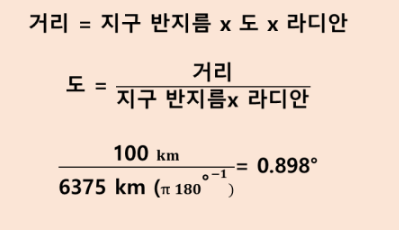

In [ ]:
latitude_range = 0.8*(180/math.pi)/6371
latitude_range

0.0071945728473498454

**2) 0.8km->경도**
- 아래 식에서 1도를 x로 잡고 거리에 0.8대입하여 방정식 만들기(서울의 위도 37N 기준)

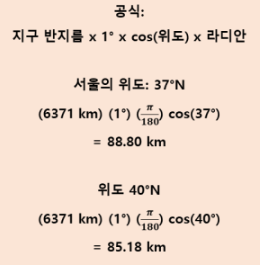

In [ ]:
longitude_range = 0.8*(180/math.pi)/math.cos(math.radians(37))/6371
longitude_range

0.009008581207369309

In [ ]:
subbusparamaphigh

,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,SumQuantile,NightrushQuantile,Lati,Long
100000002,28888,63889,0.452159,3131,73428,0.049007,1149,0.017984,137317,~최대,최소~1q,37.579183,126.996566
100000003,24303,84079,0.289050,8558,122132,0.101785,3593,0.042734,206211,~최대,~2q,37.582671,126.998340
100000005,17841,73834,0.241637,9797,49052,0.132690,3543,0.047986,122886,~최대,~2q,37.586243,127.001744
100000007,3213,13866,0.231718,1638,40142,0.118131,618,0.044569,54008,~최대,~2q,37.583295,126.970263
100000015,7268,38920,0.186742,6885,31386,0.176901,1590,0.040853,70306,~최대,~2q,37.580326,126.971050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
천호(풍납토성),1502081,9659958,0.155496,1516189,9112166,0.166392,876440,0.096183,18772124,~최대,~9q,37.538460,127.123900
청량리(서울시립대입구),1500882,10332915,0.145253,1571454,10213677,0.153858,737931,0.072249,20546592,~최대,~7q,37.580110,127.045040
합정,2810110,13035411,0.215575,2524707,12452276,0.202751,1853566,0.148854,25487687,~최대,~최대,37.550020,126.914530
혜화,2330623,9411182,0.247644,2102927,9322737,0.225570,1528671,0.163972,18733919,~최대,~최대,37.582340,127.001840


앞서 구한 위경도 범위를 +-로 하여 subbusparamaphigh에 새로운 컬럼 생성(위도범위, 경도범위)

In [ ]:
subbusparamaphigh['Latiplus']=subbusparamaphigh['Lati']+latitude_range
subbusparamaphigh['Latiminus']=subbusparamaphigh['Lati']-latitude_range
subbusparamaphigh['Longplus']=subbusparamaphigh['Lati']+longitude_range
subbusparamaphigh['Longminus']=subbusparamaphigh['Lati']-longitude_range

In [ ]:
Allcompanies

,기업명,위도,경도,주소,공/사
2,(재)예술경영지원센터,37.576675,127.001909,"서울특별시 종로구 대학로 57 (연건동) 홍익대학교대학로캠퍼스 교육동 12층, 3층",공
5,(재)우체국물류지원단,37.535523,127.085892,"서울특별시 광진구 자양로 76 (자양동) 1,4층",공
16,건설근로자공제회,37.560441,126.975920,서울특별시 중구 남대문로 109 (다동) 10층,공
20,고등과학원,37.589943,127.056703,서울특별시 동대문구 회기로 85 (청량리동) 고등과학원 1호관,공
24,과학기술일자리진흥원,37.563225,126.964621,서울특별시 서대문구 충정로 13 (충정로3가) 7층,공
...,...,...,...,...,...
38,오리온,37.535863,126.969592,서울특별시 용산구 백범로90다길 13,사
39,유한양행,37.512597,126.954317,서울특별시 동작구 노량진로 74,사
40,LG,37.525303,126.924190,서울특별시 영등포구 여의대로 128,사
42,키움증권,37.521850,126.927517,서울특별시 영등포구 여의나루로4길 18,사


Allcompanies의 위도, 경도가 앞선 subbusparamaphigh 의 위경도 범위에 속하면 Allcompanies 의 '기업명' 을 역 이름 옆에 붙이기

In [ ]:
subbusparamaphigh=subbusparamaphigh.reset_index(drop=False)
subbusparamaphigh

,index,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,SumQuantile,NightrushQuantile,Lati,Long,Latiplus,Latiminus,Longplus,Longminus
0,100000002,28888,63889,0.452159,3131,73428,0.049007,1149,0.017984,137317,~최대,최소~1q,37.579183,126.996566,37.586378,37.571988,37.588192,37.570174
1,100000003,24303,84079,0.289050,8558,122132,0.101785,3593,0.042734,206211,~최대,~2q,37.582671,126.998340,37.589866,37.575477,37.591680,37.573663
2,100000005,17841,73834,0.241637,9797,49052,0.132690,3543,0.047986,122886,~최대,~2q,37.586243,127.001744,37.593438,37.579048,37.595252,37.577234
3,100000007,3213,13866,0.231718,1638,40142,0.118131,618,0.044569,54008,~최대,~2q,37.583295,126.970263,37.590490,37.576101,37.592304,37.574287
4,100000015,7268,38920,0.186742,6885,31386,0.176901,1590,0.040853,70306,~최대,~2q,37.580326,126.971050,37.587520,37.573131,37.589334,37.571317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,천호(풍납토성),1502081,9659958,0.155496,1516189,9112166,0.166392,876440,0.096183,18772124,~최대,~9q,37.538460,127.123900,37.545655,37.531265,37.547469,37.529451
1309,청량리(서울시립대입구),1500882,10332915,0.145253,1571454,10213677,0.153858,737931,0.072249,20546592,~최대,~7q,37.580110,127.045040,37.587305,37.572915,37.589119,37.571101
1310,합정,2810110,13035411,0.215575,2524707,12452276,0.202751,1853566,0.148854,25487687,~최대,~최대,37.550020,126.914530,37.557215,37.542825,37.559029,37.541011
1311,혜화,2330623,9411182,0.247644,2102927,9322737,0.225570,1528671,0.163972,18733919,~최대,~최대,37.582340,127.001840,37.589535,37.575145,37.591349,37.573331


In [ ]:
for v in Allcompanies['위도']:
    df3 = subbusparamaphigh[(subbusparamaphigh['Latiminus'] < v) &  (subbusparamaphigh['Latiplus'] > v)]
for v in Allcompanies['경도']:
    df4 = subbusparamaphigh[(subbusparamaphigh['Latiminus'] < v) &  (subbusparamaphigh['Latiplus'] > v)]
df3=pd.DataFrame(df3)
df4=pd.DataFrame(df4)

df34 = pd.concat([df3, df4])
#drop if column have just one value
for col in df34.columns:
    if len(df34[col].unique()) == 1:
        df34.drop(col,inplace=True,axis=1)

In [ ]:
df34

,index,MorningRush,sumalltime_OUT,MorningRushratio,OffRush,sumalltime_IN,OffRushratio,NightRush,NightRushratio,SumINOUT,NightrushQuantile,Lati,Long,Latiplus,Latiminus,Longplus,Longminus
135,102000247,1753,27077,0.064741,7106,36755,0.262437,3120,0.115227,63832,~8q,37.517671,126.958593,37.524866,37.510477,37.526680,37.508663
630,114000115,2330,15052,0.154797,2378,42712,0.157986,923,0.061321,57764,~3q,37.517828,126.841864,37.525022,37.510633,37.526836,37.508819
635,114000148,6806,30180,0.225514,4566,29207,0.151292,2021,0.066965,59387,~4q,37.519288,126.853454,37.526483,37.512094,37.528297,37.510280
637,114000153,8651,40842,0.211816,6228,20302,0.152490,2471,0.060501,61144,~3q,37.518163,126.866163,37.525357,37.510968,37.527171,37.509154
696,116000001,4654,70382,0.066125,15694,211988,0.222983,8989,0.127717,282370,~8q,37.509752,126.889423,37.516947,37.502558,37.518761,37.500744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,삼성(무역센터),6461956,13632509,0.474011,4681772,13559350,0.345280,1999911,0.147493,27191859,~최대,37.508840,127.063160,37.516035,37.501645,37.517849,37.499831
1292,신도림,2272138,14161117,0.160449,2283272,14113272,0.161782,1263805,0.089547,28274389,~8q,37.508660,126.891350,37.515855,37.501465,37.517669,37.499651
1294,신사,2772643,8350789,0.332022,2109529,7962030,0.264949,1313273,0.164942,16312819,~최대,37.516330,127.020110,37.523525,37.509135,37.525339,37.507321
1300,영등포,2608638,11605986,0.224767,2520899,11308696,0.222917,1630577,0.144188,22914682,~최대,37.515500,126.907630,37.522695,37.508305,37.524509,37.506491


df34는 직장-반경 0.8km이내 역들만 남긴 데이터임. 이들을 가지고 다시 야근시간 승차 맵 그려봐야 더욱 정확함.

In [ ]:
colormap2 = cm.LinearColormap(colors=['lightblue','red'], index=[0.013753,0.184895],vmin=0.013753,vmax=0.184895)
reversemap2 = folium.Map(location=center, zoom_start=10)

lat = list(df34.Lati)
lon = list(df34.Long)
NightRushratiolist = list(df34.NightRushratio)

for loc, N in zip(zip(lat, lon), NightRushratiolist):
  folium.Circle(
    location=loc,
    radius=100,
    fill=True,
    color=colormap(N),
    fill_opacity=0.5
  ).add_to(reversemap2)

reversemap2.add_child(colormap2)

reversemap2ttle_html = '''
             <h3 align="center" style="font-size:20px"><b>Reverse-칼퇴확률 map</b></h3>
             '''
reversemap2.get_root().html.add_child(folium.Element(reversemap2ttle_html))

reversemap2.save('Reverse-칼퇴확률2.html')
reversemap2

직장-반경 0.8km이내 역 중 야근시간대 특히 붐비는 곳은 삼성역, 신사역, 여의대로, 신길동 일대, 영등포역, 잠실역..

#퇴근시간 승차 히트맵 위에 기업 위치를 찍어 기업위치 확인



In [ ]:
# 공기업에는 Green Marker, 사기업에는 Pink Marker 그리기
locationlist1  = a[["위도","경도"]].values.tolist()
labels1 = a[["기업명"]].values.tolist()

locationlist2  = b[["위도","경도"]].values.tolist()
labels2 = b[["기업명"]].values.tolist()

# 직장 이름 라벨 마커 찍기
for point in range(len(locationlist1)):
    folium.Marker(locationlist1[point], icon=folium.Icon(color='green'), popup=labels1[point]).add_to(Noonseungcha)

for point in range(len(locationlist2)):
    folium.Marker(locationlist2[point], icon=folium.Icon(color='pink'), popup=labels2[point]).add_to(Noonseungcha)

title5_html = '''
             <h3 align="center" style="font-size:20px"><b>퇴근시간 칼퇴가능기업</b></h3>
             '''
Noonseungcha.get_root().html.add_child(folium.Element(title5_html))

Noonseungcha.save('Noonseungcha.html')
Noonseungcha


*   모닝 출근러시시간대 하차자를 고려하지 않고 퇴근러시시간대 승차자만 고려한 히트맵 위에 기업을 찍은 맵.

*   붉은 곳에 입지할수록, 퇴근시간이 일정한 기업으로 간주할 수 있음.



#기업의 칼퇴가능여부 확인 : Reverse 칼퇴 확률맵 완성
-야근후 퇴근시간대 승차맵(Reverse-칼퇴 확률맵) 위에 기업 위치를 찍어 기업의 칼퇴여부 확인

In [ ]:
for point in range(len(locationlist1)):
    folium.Marker(locationlist1[point], icon=folium.Icon(color='green'), popup=labels1[point]).add_to(reversemap)

for point in range(len(locationlist2)):
    folium.Marker(locationlist2[point], icon=folium.Icon(color='pink'), popup=labels2[point]).add_to(reversemap)

titlemapk_html = '''
             <h3 align="center" style="font-size:20px"><b>Reverse-칼퇴하는 기업</b></h3>
             '''
reversemap.get_root().html.add_child(folium.Element(titlemapk_html))

reversemap.save('reversemap.html')
reversemap

* 해당 Map은 야근시간대(PM20:00~22:00) 의 승차자 집중 지역과 직장을 연결한 Map임.
* 삼성역을 중심으로 한 영동대로 부근, 을지로 부근, 회기로 부근, 디지털미디어시티역 부근, 가산디지털단지역 부근이 야근시간대 승차자가 집중되었음.
* 반면, 영등포구 여의대로 일대는 야근시간대 승차자 집중도가 낮은 것으로 나타나, 비교적 정시퇴근이 가능한 직장이 있다고 추정할 수 있음.

야근하는 기업 정확하게 딱 하나 잡음. 유한양행

# 아이디어 활용방안

* 본 분석의 목적은 출퇴근 러시아워의 직장 인근 지하철역, 버스정류장 승하차자 수 데이터를 통해 직장의 출퇴근 시간 자율성을 확인하고, 
* 내부자 입장을 오롯이 믿을 수밖에 없는 입장이었던 구직자에게 대안적인 퇴근경향 정보를 제공하여 기업정보의 예측가능성 및 신뢰성을 높이기 위함임
* 출퇴근 시간 예측가능성은 구직자 개개인의 향후 가족계획, 일 이후의 삶, 여가 및 자기계발에 대한 중요도에 따라 유용하게 사용될 수 있음. 


*  단, 정시출퇴근이 가능한 것이 꼭 좋다는 절대선을 의미하지는 않음. 
 - 그럼에도, 야근시간대에 승차집중도가 낮은 역 주변에 직장이 위치했다는 것은 퇴근시간대에 사람들이 퇴근할 수 있음을 의미하므로 집중도가 높은 기업보다 야근을 덜 하는, 개방적인 조직문화를 가졌다고 추측할 수는 있음.



